In [1]:
import pandas as pd
import numpy as np
import random
import os
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic' # 폰트 변경
plt.rcParams['axes.unicode_minus'] = False # 축 값 마이너스 깨짐 해결
from collections import defaultdict
from scipy import stats as stats
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import KFold
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

In [3]:
# 데이터 불러오기
# pd.read_csv() 함수를 사용해서 데이터를 읽어오는 코드입니다.
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# 데이터를 확인하기 위해 head() 함수를 사용합니다.
train.head(5)

,ID,나이,키(cm),몸무게(kg),BMI,시력,충치,공복 혈당,혈압,중성 지방,혈청 크레아티닌,콜레스테롤,고밀도지단백,저밀도지단백,헤모글로빈,요 단백,간 효소율,label
0,TRAIN_0000,35,170,70,24.22,1.10,1,98,40,80,1.3,211,75,120,15.9,1,1.53,1
1,TRAIN_0001,40,150,55,24.44,1.00,0,173,39,104,0.6,251,46,184,11.8,1,1.45,0
2,TRAIN_0002,60,170,50,17.30,0.75,0,96,40,61,0.8,144,43,89,15.3,1,1.04,0
3,TRAIN_0003,40,150,45,20.00,0.50,0,92,40,46,0.7,178,66,110,13.4,1,1.18,0
4,TRAIN_0004,55,155,65,27.06,1.00,0,87,42,95,0.9,232,62,151,13.8,1,1.32,0


In [4]:
train.columns

Index(['ID', '나이', '키(cm)', '몸무게(kg)', 'BMI', '시력', '충치', '공복 혈당', '혈압',
       '중성 지방', '혈청 크레아티닌', '콜레스테롤', '고밀도지단백', '저밀도지단백', '헤모글로빈', '요 단백',
       '간 효소율', 'label'],
      dtype='object')

In [5]:
x_corr = train.drop(['ID'], axis = 1)

In [6]:
x_corr

,나이,키(cm),몸무게(kg),BMI,시력,충치,공복 혈당,혈압,중성 지방,혈청 크레아티닌,콜레스테롤,고밀도지단백,저밀도지단백,헤모글로빈,요 단백,간 효소율,label
0,35,170,70,24.22,1.10,1,98,40,80,1.3,211,75,120,15.9,1,1.53,1
1,40,150,55,24.44,1.00,0,173,39,104,0.6,251,46,184,11.8,1,1.45,0
2,60,170,50,17.30,0.75,0,96,40,61,0.8,144,43,89,15.3,1,1.04,0
3,40,150,45,20.00,0.50,0,92,40,46,0.7,178,66,110,13.4,1,1.18,0
4,55,155,65,27.06,1.00,0,87,42,95,0.9,232,62,151,13.8,1,1.32,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,25,170,65,22.49,1.50,0,87,45,141,1.2,184,44,112,14.9,1,1.50,0
6996,60,165,65,23.88,0.90,0,87,45,82,0.9,184,64,103,14.3,1,1.47,1
6997,40,180,100,30.86,1.20,0,97,44,87,0.9,178,54,107,15.6,1,1.00,0
6998,60,150,55,24.44,0.60,0,89,57,161,0.6,157,49,76,14.4,1,1.00,0


<Axes: >

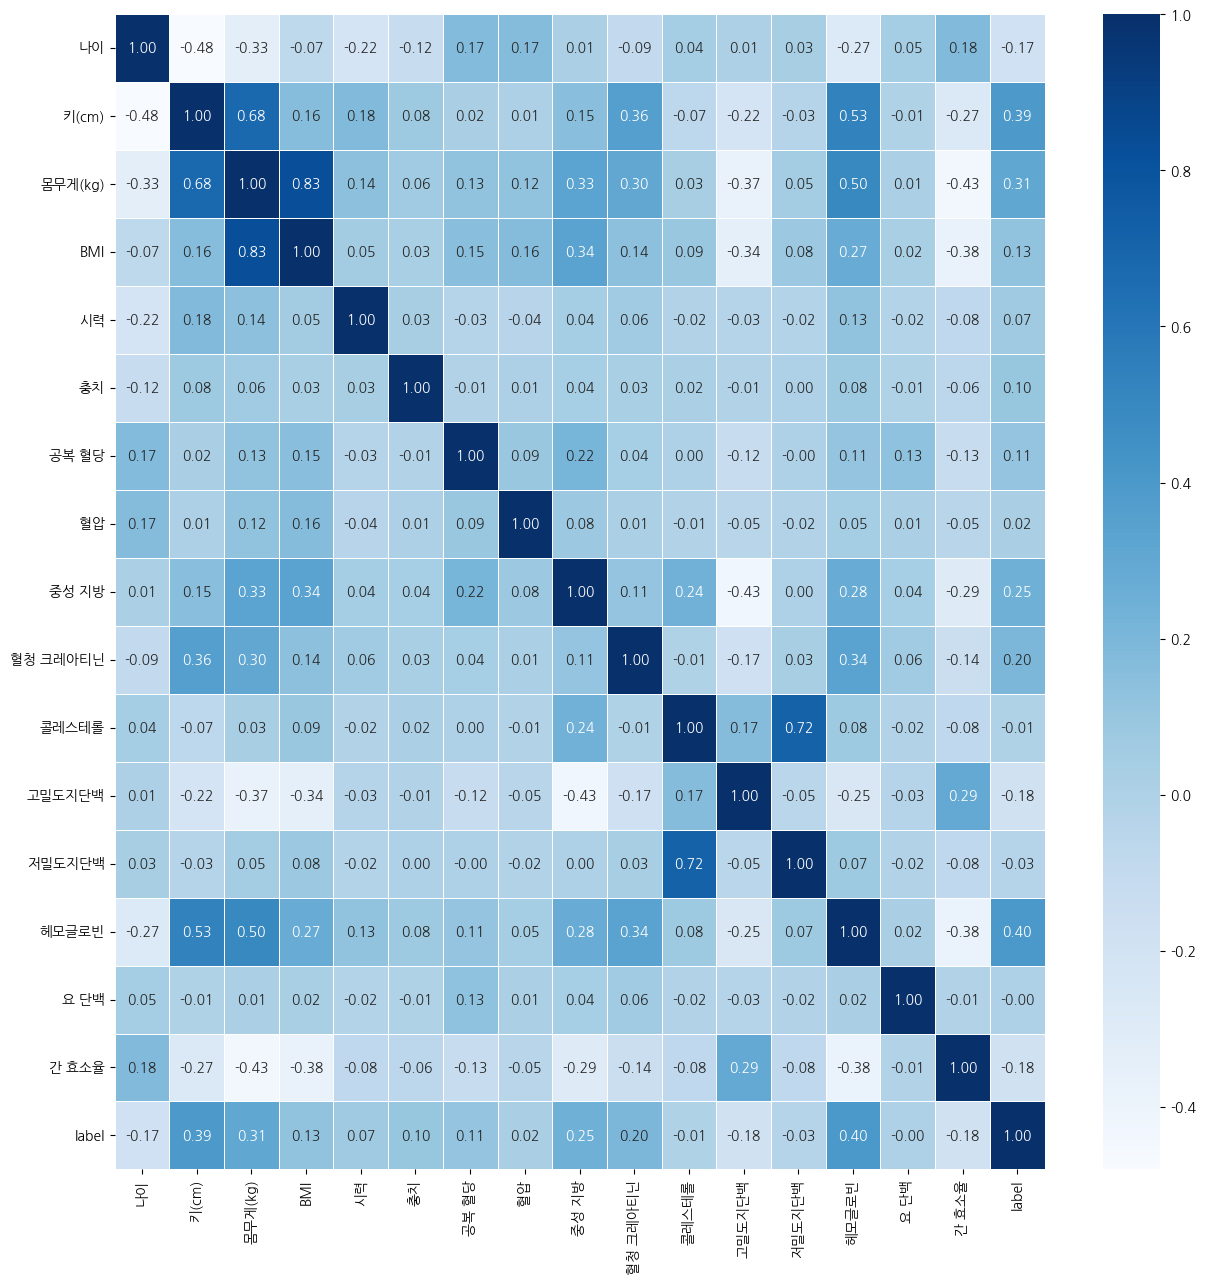

In [7]:
# 상관계수 시각화
plt.figure(figsize=(15,15))
sns.heatmap(data = x_corr.corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')

In [8]:
# 'ID', 'label', '나이', '키(cm)', '몸무게(kg)', 'BMI', '헤모글로빈', '혈청 크레아티닌', '고밀도지단백', '콜레스테롤', '저밀도지단백', '중성 지방'
# 'ID', '나이', '키(cm)', '몸무게(kg)', 'BMI', '헤모글로빈', '혈청 크레아티닌', '고밀도지단백', '콜레스테롤', '저밀도지단백', '중성 지방'

In [9]:
x_train = train.drop(['ID', 'label'], axis = 1)
y_train = train['label']

x_test = test.drop(['ID'], axis = 1)

In [10]:
x_train.head()

,나이,키(cm),몸무게(kg),BMI,시력,충치,공복 혈당,혈압,중성 지방,혈청 크레아티닌,콜레스테롤,고밀도지단백,저밀도지단백,헤모글로빈,요 단백,간 효소율
0,35,170,70,24.22,1.10,1,98,40,80,1.3,211,75,120,15.9,1,1.53
1,40,150,55,24.44,1.00,0,173,39,104,0.6,251,46,184,11.8,1,1.45
2,60,170,50,17.30,0.75,0,96,40,61,0.8,144,43,89,15.3,1,1.04
3,40,150,45,20.00,0.50,0,92,40,46,0.7,178,66,110,13.4,1,1.18
4,55,155,65,27.06,1.00,0,87,42,95,0.9,232,62,151,13.8,1,1.32


In [11]:
x_train.tail()

,나이,키(cm),몸무게(kg),BMI,시력,충치,공복 혈당,혈압,중성 지방,혈청 크레아티닌,콜레스테롤,고밀도지단백,저밀도지단백,헤모글로빈,요 단백,간 효소율
6995,25,170,65,22.49,1.50,0,87,45,141,1.2,184,44,112,14.9,1,1.50
6996,60,165,65,23.88,0.90,0,87,45,82,0.9,184,64,103,14.3,1,1.47
6997,40,180,100,30.86,1.20,0,97,44,87,0.9,178,54,107,15.6,1,1.00
6998,60,150,55,24.44,0.60,0,89,57,161,0.6,157,49,76,14.4,1,1.00
6999,50,165,65,23.88,0.65,0,104,47,124,0.8,251,56,170,13.6,1,0.81


In [12]:
x_train.columns

Index(['나이', '키(cm)', '몸무게(kg)', 'BMI', '시력', '충치', '공복 혈당', '혈압', '중성 지방',
       '혈청 크레아티닌', '콜레스테롤', '고밀도지단백', '저밀도지단백', '헤모글로빈', '요 단백', '간 효소율'],
      dtype='object')

In [13]:
# 칼럼 데이터 타입 확인
for col in x_train.columns:
    data_type = x_train[f'{col}'].dtype
    print(f'{col}: {data_type}')

나이: int64
키(cm): int64
몸무게(kg): int64
BMI: float64
시력: float64
충치: int64
공복 혈당: int64
혈압: int64
중성 지방: int64
혈청 크레아티닌: float64
콜레스테롤: int64
고밀도지단백: int64
저밀도지단백: int64
헤모글로빈: float64
요 단백: int64
간 효소율: float64


In [14]:
x_train.shape

(7000, 16)

1. 흡연하면 올라가는 수치 
* 충치, 혈당, 혈압, 중성지방, 혈청 크레아티닌, 저밀도지단백, 헤모글로빈, 요단백, 
2. 흡연하면 내려가는 수치 
* 콜레스테롤, 시력, 고밀도지단백, 간 효소율

In [15]:
# 수치형 변수의 분포 확인
x_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
나이,7000.0,43.973571,12.063793,20.00,35.00,40.00,50.00,85.00
키(cm),7000.0,164.781429,9.170213,135.00,160.00,165.00,170.00,190.00
몸무게(kg),7000.0,65.932857,12.978702,30.00,55.00,65.00,75.00,130.00
BMI,7000.0,24.144423,3.501945,14.27,21.60,23.88,26.12,42.45
시력,7000.0,1.011650,0.427828,0.10,0.80,1.00,1.20,9.90
충치,7000.0,0.227429,0.419202,0.00,0.00,0.00,0.00,1.00
공복 혈당,7000.0,99.331857,21.129670,57.00,89.00,96.00,104.00,386.00
혈압,7000.0,45.532857,8.820611,14.00,40.00,45.00,50.00,91.00
중성 지방,7000.0,127.144714,73.918492,21.00,74.00,107.00,161.00,999.00
혈청 크레아티닌,7000.0,0.884900,0.241523,0.10,0.80,0.90,1.00,10.00


In [16]:
# 결측치 개수 파악
x_train.isnull().sum()

나이          0
키(cm)       0
몸무게(kg)     0
BMI         0
시력          0
충치          0
공복 혈당       0
혈압          0
중성 지방       0
혈청 크레아티닌    0
콜레스테롤       0
고밀도지단백      0
저밀도지단백      0
헤모글로빈       0
요 단백        0
간 효소율       0
dtype: int64

In [17]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   나이        7000 non-null   int64  
 1   키(cm)     7000 non-null   int64  
 2   몸무게(kg)   7000 non-null   int64  
 3   BMI       7000 non-null   float64
 4   시력        7000 non-null   float64
 5   충치        7000 non-null   int64  
 6   공복 혈당     7000 non-null   int64  
 7   혈압        7000 non-null   int64  
 8   중성 지방     7000 non-null   int64  
 9   혈청 크레아티닌  7000 non-null   float64
 10  콜레스테롤     7000 non-null   int64  
 11  고밀도지단백    7000 non-null   int64  
 12  저밀도지단백    7000 non-null   int64  
 13  헤모글로빈     7000 non-null   float64
 14  요 단백      7000 non-null   int64  
 15  간 효소율     7000 non-null   float64
dtypes: float64(5), int64(11)
memory usage: 875.1 KB


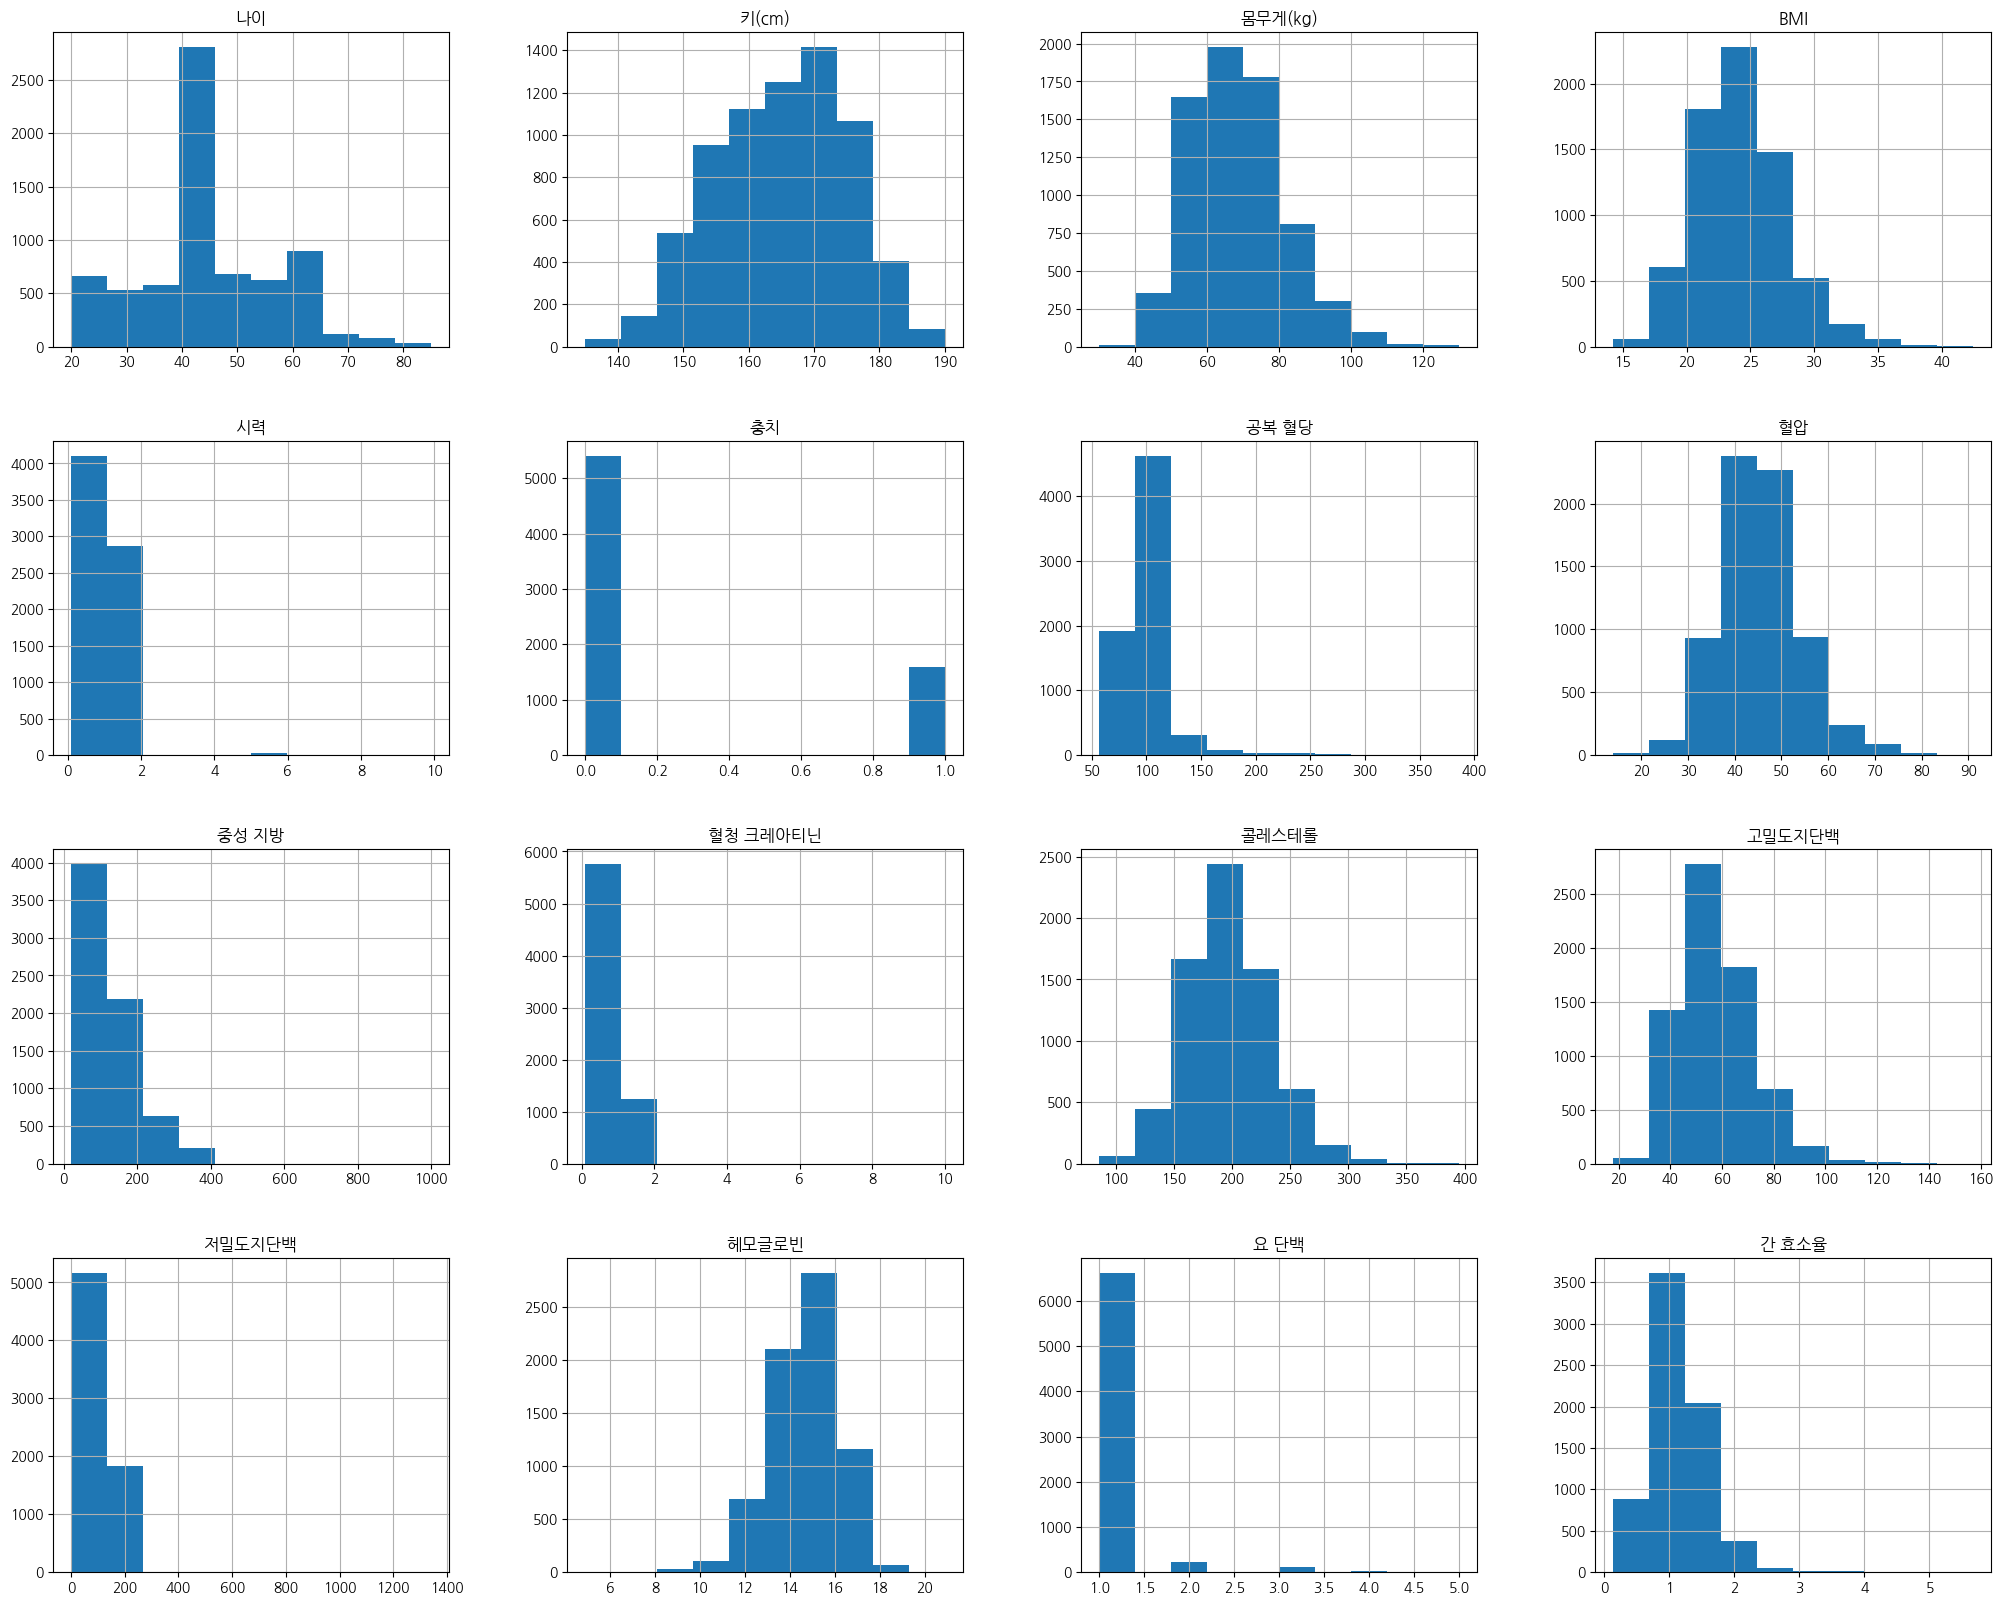

In [18]:
# 변수 분포 시각화
x_train.hist(figsize=(25,20))
plt.show()

<Axes: >

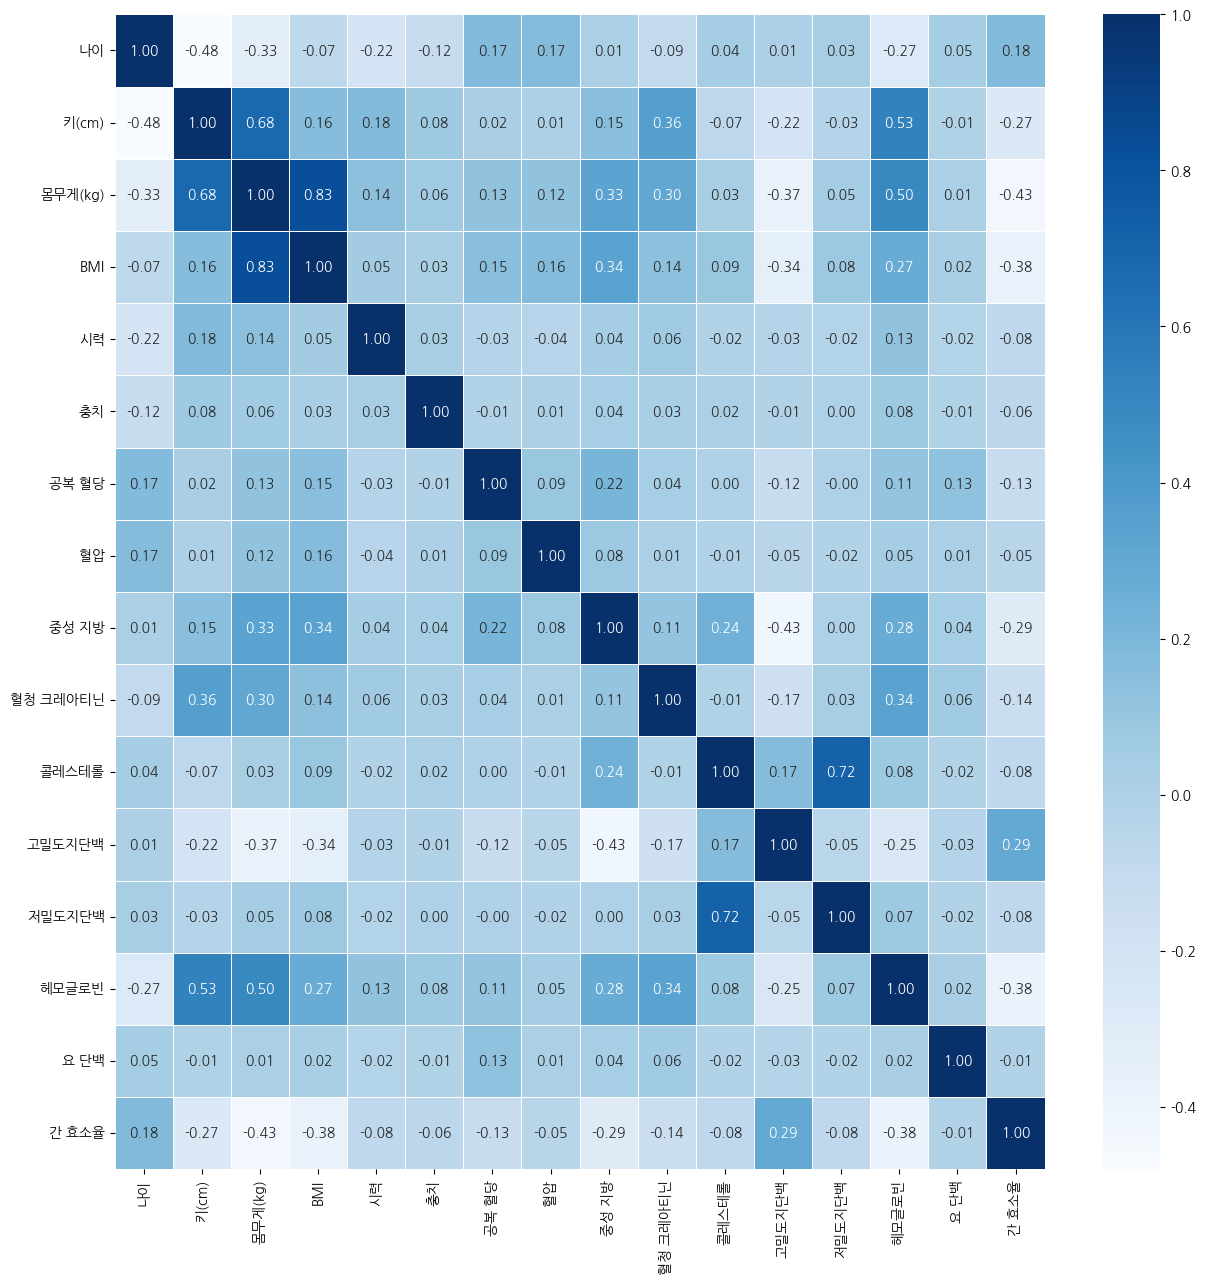

In [19]:
# 상관계수 시각화
plt.figure(figsize=(15,15))
sns.heatmap(data = x_train.corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')

In [20]:
def create_submission(model, x_test):
    pred = model.predict(x_test)
    submit = pd.read_csv('data/sample_submission.csv')
    # 예측한 값을 TARGET 컬럼에 할당합니다.
    submit['label'] = pred
    submit.head()
    # 예측한 결과를 파일로 저장합니다. index 인자의 값을 False로 설정하지 않으면 제출이 정상적으로 진행되지 않습니다.
    now = datetime.datetime.now()
    time_now = now.strftime('%Y-%m-%d_%H-%M-%S') 
    submit.to_csv(f'results/{str(model)}_submission_{str(time_now)}.csv', index = False)

In [21]:
# 스케일러 적용
scaler = MinMaxScaler()
scaler = scaler.fit(x_train)

# 훈련 데이터에 스케일러 적용
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [22]:
def run(x_train, model):
    print(f'Model = {model}')

    kfold = KFold(n_splits=3, shuffle=True)
    model_kf_acc = []

    n_iter = 0
    for train_idx, valid_idx in kfold.split(x_train):
        X_train_, X_valid_ = x_train[train_idx], x_train[valid_idx]
        y_train_, y_valid_ = y_train[train_idx], y_train[valid_idx]
        
        # 훈련
        model.fit(X_train_, y_train_)
        model_pred = model.predict(X_valid_)
        model_acc = accuracy_score(model_pred, y_valid_)
        n_iter += 1
        model_kf_acc.append([n_iter, model_acc, model])
        print(f'KFold {n_iter} 교차검증 정확도 : {model_acc}, 학습 데이터 크기:{X_train_.shape[0]}, 검증 데이터 크기:{y_train_.shape[0]}')

    model_kf_acc_sort = model_kf_acc
    model_kf_acc_sort.sort(key=lambda x : x[1], reverse=True)
    # KFold 검증 후 가장 정확도가 높은 모델 선택
    model = model_kf_acc_sort[0][2]
    print(f'교차검증 중 가장 높은 정확도  : KFold {model_kf_acc_sort[0][0]}, {model_kf_acc_sort[0][1]}\n')
    
    # create_submission(model, x_test)
    
    return model_kf_acc

In [23]:
models = [
    DecisionTreeClassifier(),
    RandomForestClassifier(random_state=42),
    AdaBoostClassifier(random_state=42),
    SVC(random_state=42),
    SGDClassifier(random_state=42),
    LogisticRegression(random_state=42),
    GradientBoostingClassifier(random_state=42),
    XGBClassifier(),
    XGBRFClassifier(), 
    CatBoostClassifier(random_state=42),
    LGBMClassifier(),
]

In [24]:
results = defaultdict(list)
max_acc = 0
final_model = None

for model in models:
    model_kf_acc = run(x_train, model=model)
    for i, result in enumerate(model_kf_acc):
        results[f'{str(result[2])}'].append(str(result[1]))
        if result[1] >= max_acc:
            max_acc = result[1]
            final_model = result[2]
            
print(f"가장 높은 정확도 모델 = {final_model}\n가장 높은 정확도 = {max_acc}")
create_submission(final_model, x_test)

# 모든 Fold 별 결과 확인
total_fold_df = pd.DataFrame(results, index=['Fold1', 'Fold2', 'Fold3'])
total_fold_df

Model = DecisionTreeClassifier()
KFold 1 교차검증 정확도 : 0.6748071979434447, 학습 데이터 크기:4666, 검증 데이터 크기:4666
KFold 2 교차검증 정확도 : 0.6772396056579512, 학습 데이터 크기:4667, 검증 데이터 크기:4667
KFold 3 교차검증 정확도 : 0.6793827689669952, 학습 데이터 크기:4667, 검증 데이터 크기:4667
교차검증 중 가장 높은 정확도  : KFold 3, 0.6793827689669952

Model = RandomForestClassifier(random_state=42)
KFold 1 교차검증 정확도 : 0.7352185089974294, 학습 데이터 크기:4666, 검증 데이터 크기:4666
KFold 2 교차검증 정확도 : 0.7226746678096871, 학습 데이터 크기:4667, 검증 데이터 크기:4667
KFold 3 교차검증 정확도 : 0.7158165452207458, 학습 데이터 크기:4667, 검증 데이터 크기:4667
교차검증 중 가장 높은 정확도  : KFold 1, 0.7352185089974294

Model = AdaBoostClassifier(random_state=42)
KFold 1 교차검증 정확도 : 0.7017994858611826, 학습 데이터 크기:4666, 검증 데이터 크기:4666
KFold 2 교차검증 정확도 : 0.7282468924132018, 학습 데이터 크기:4667, 검증 데이터 크기:4667
KFold 3 교차검증 정확도 : 0.7132447492498929, 학습 데이터 크기:4667, 검증 데이터 크기:4667
교차검증 중 가장 높은 정확도  : KFold 2, 0.7282468924132018

Model = SVC(random_state=42)
KFold 1 교차검증 정확도 : 0.7232219365895458, 학습 데이터 크기:4666, 검증 데이터 크기:4666

,DecisionTreeClassifier(),RandomForestClassifier(random_state=42),AdaBoostClassifier(random_state=42),SVC(random_state=42),SGDClassifier(random_state=42),LogisticRegression(random_state=42),GradientBoostingClassifier(random_state=42),"XGBClassifier(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n gamma=None, gpu_id=None, grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=None, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None, max_leaves=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimators=100, n_jobs=None, num_parallel_tree=None,\n predictor=None, random_state=None, ...)","XGBRFClassifier(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bytree=None,\n early_stopping_rounds=None, enable_categorical=False,\n eval_metric=None, feature_types=None, gamma=None, gpu_id=None,\n grow_policy=None, importance_type=None,\n interaction_constraints=None, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None, max_leaves=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimators=100, n_jobs=None, num_parallel_tree=None,\n objective='binary:logistic', predictor=None, random_state=None,\n reg_alpha=None, ...)",<catboost.core.CatBoostClassifier object at 0x7fe97c1275b0>,LGBMClassifier()
Fold1,0.6793827689669952,0.7352185089974294,0.7282468924132018,0.7363909129875696,0.7119588512644663,0.715387912558937,0.7283633247643531,0.7239605657951136,0.7295327903986284,0.7359622803257608,0.7338191170167166
Fold2,0.6772396056579512,0.7226746678096871,0.7132447492498929,0.7232219365895458,0.7017994858611826,0.7111015859408487,0.7222460351478782,0.712816116588084,0.71795970852979,0.7270779777206512,0.7240788346186804
Fold3,0.6748071979434447,0.7158165452207458,0.7017994858611826,0.7192456065152164,0.6755250750107158,0.696229648671808,0.7183883411915988,0.707369323050557,0.7112253641816624,0.7162451778825546,0.7196742391770253
